<a href="https://colab.research.google.com/github/salimhammadi15/Balance-sheet-parsing/blob/main/balance_sheet_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Importing dependencies 

In [1162]:
# !pip install pdf2image
# !apt-get install -y poppler-utils

In [1163]:
# !python3 -m pip install paddlepaddle-gpu
# !pip install "paddleocr>=2.0.1"
# !pip install protobuf==3.20.0
# !git clone https://github.com/PaddlePaddle/PaddleOCR.git

In [1164]:
# !wget https://paddleocr.bj.bcebos.com/whl/layoutparser-0.0.0-py3-none-any.whl
# !pip install -U layoutparser-0.0.0-py3-none-any.whl

In [1165]:
import cv2
import numpy as np
import pandas as pd 
import tensorflow as tf
import layoutparser as lp
import matplotlib.pyplot as plt
from PIL import Image
from pdf2image import convert_from_path
from paddleocr import PaddleOCR, draw_ocr

# II. pdf to image

In [1166]:
image_path = "/content/balance-sheet.jpg"

In [1167]:
# !mkdir pages

In [1168]:
# images = convert_from_path('test.pdf')
# for i in range(len(images)):
#     images[i].save('pages/page'+str(i)+'.jpg', 'JPEG')

# III. Table Extraction

In [1169]:
# load model
model = lp.PaddleDetectionLayoutModel(config_path="lp://PubLayNet/ppyolov2_r50vd_dcn_365e_publaynet/config",
                                threshold=0.5,
                                label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"},
                                enforce_cpu=False,
                                enable_mkldnn=True)

In [1170]:
image = cv2.imread(image_path)
# detect
layout = model.detect(image)

In [1171]:
layout

Layout(_blocks=[TextBlock(block=Rectangle(x_1=21.741058349609375, y_1=93.13003540039062, x_2=551.446533203125, y_2=836.1513671875), text=None, id=None, type=Table, parent=None, next=None, score=0.9256621599197388)], page_data={})

## i. Before

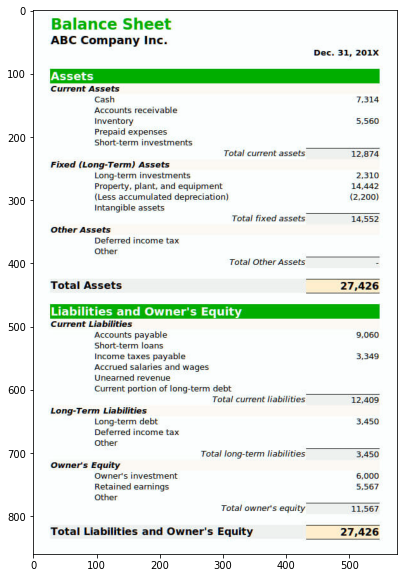

In [1172]:
plt.figure(figsize=(20, 10))
plt.imshow(image)

## ii. After

In [1173]:
for l in layout:
    if l.type == 'Table':
        x_1 = int(l.block.x_1)
        y_1 = int(l.block.y_1)
        x_2 = int(l.block.x_2)
        y_2 = int(l.block.y_2)
    
        break

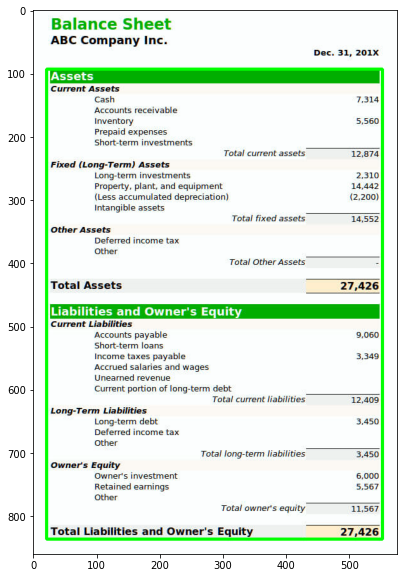

In [1174]:
top_left = (x_1, y_1)
bottom_right = (x_2,y_2)
# Drawing the rectangle using top_left and bottom_right coordinates and giving a descent color((0,255,0)) and thickness(3).
img = cv2.rectangle(image,top_left,bottom_right,(0,255,0),3)

# Showing the image
plt.figure(figsize=(20,10))
plt.imshow(img)

In [1175]:
cv2.imwrite('ext_im.jpg', image[y_1:y_2,x_1:x_2])

True

# IV. Text Detection and Recognition

In [1176]:
ocr = PaddleOCR(lang='en')
image_path = '/content/ext_im.jpg'
image_cv = cv2.imread(image_path)
image_height = image_cv.shape[0]
image_width = image_cv.shape[1]

[2022/08/16 09:31:51] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_fce_box_type='poly', det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='quad', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='f

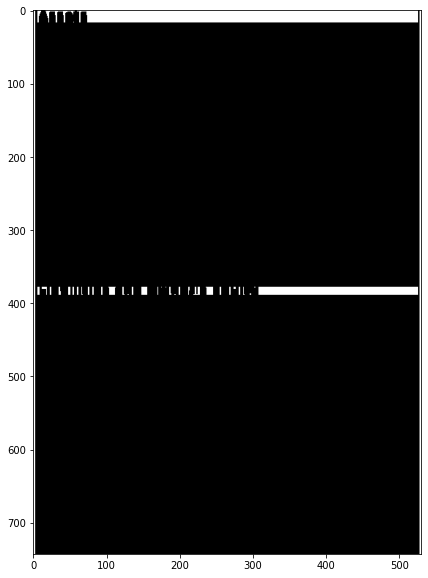

[0, 528]


In [1177]:
img_vert = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_cv = cv2.imread(image_path)
#thresholding the image to a binary image

thresh,img_bin = cv2.threshold(img_vert,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
#inverting the image 
img_bin = 255-img_bin

# Length(width) of kernel as 100th of total width
kernel_len = np.array(img_vert).shape[1]//100
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical = cv2.dilate(image_1, ver_kernel, iterations=3)

#Plot the generated image
plt.figure(figsize=(20, 10))
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

cnts = cv2.findContours(vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

steps = []
for c in cnts:
  if abs(c[0][0][1] - c[1][0][1])  > (image_height * 0.5 ):
    steps.append(c[0][0][0])

steps.sort()

print(steps)

vert_lines = 0
for c in steps:
  # cv2.line(image_cv, (c,0), (c,image_height), (255,0,0), 1)
  image_cv = np.insert(image_cv, c  + vert_lines*30, np.zeros([30,image_height,3], dtype=np.uint8) + 255, axis=1) 
  vert_lines += 1

In [1178]:
image_height = image_cv.shape[0]
image_width = image_cv.shape[1]
cv2.imwrite('detections.jpg', image_cv)
output = ocr.ocr('/content/detections.jpg')

[2022/08/16 09:31:53] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2022/08/16 09:31:53] ppocr DEBUG: dt_boxes num : 56, elapse : 0.048566341400146484
[2022/08/16 09:31:53] ppocr DEBUG: rec_res num  : 56, elapse : 0.17168045043945312


In [1179]:
print(output)

[[[[34.0, 2.0], [107.0, 4.0], [106.0, 21.0], [34.0, 19.0]], ('Assets', 0.9951169490814209)], [[[36.0, 24.0], [145.0, 24.0], [145.0, 38.0], [36.0, 38.0]], ('Current Assets', 0.9745849370956421)], [[[104.0, 41.0], [140.0, 41.0], [140.0, 57.0], [104.0, 57.0]], ('Cash', 0.9966511130332947)], [[[517.0, 41.0], [557.0, 41.0], [557.0, 57.0], [517.0, 57.0]], ('7,314', 0.9002591371536255)], [[[106.0, 59.0], [238.0, 59.0], [238.0, 73.0], [106.0, 73.0]], ('Accounts receivable', 0.9734552502632141)], [[[103.0, 72.0], [170.0, 75.0], [170.0, 92.0], [102.0, 90.0]], ('Inventory', 0.994663655757904)], [[[517.0, 75.0], [556.0, 75.0], [556.0, 90.0], [517.0, 90.0]], ('5,560', 0.9713263511657715)], [[[106.0, 93.0], [222.0, 93.0], [222.0, 107.0], [106.0, 107.0]], ('Prepaid expenses', 0.9741697311401367)], [[[106.0, 110.0], [261.0, 110.0], [261.0, 124.0], [106.0, 124.0]], ('Short-term investments', 0.9881784915924072)], [[[309.0, 126.0], [439.0, 126.0], [439.0, 140.0], [309.0, 140.0]], ('Total current assets'

## i. Before

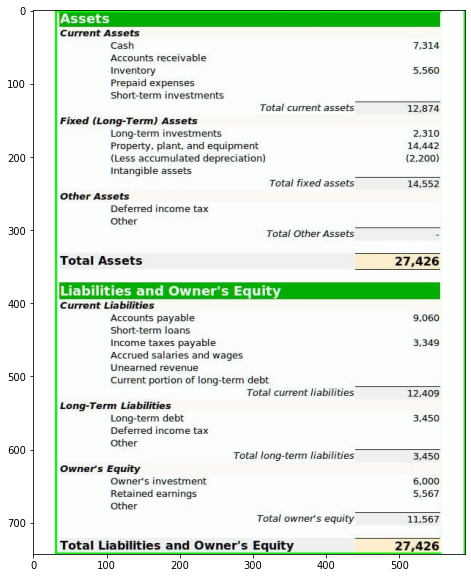

In [1180]:
plt.figure(figsize=(20, 10))
plt.imshow(image_cv)

## ii. After

In [1181]:
boxes = [line[0] for line in output]
texts = [line[1][0] for line in output]
probabilities = [line[1][1] for line in output]

In [1182]:
image_boxes = image_cv.copy()

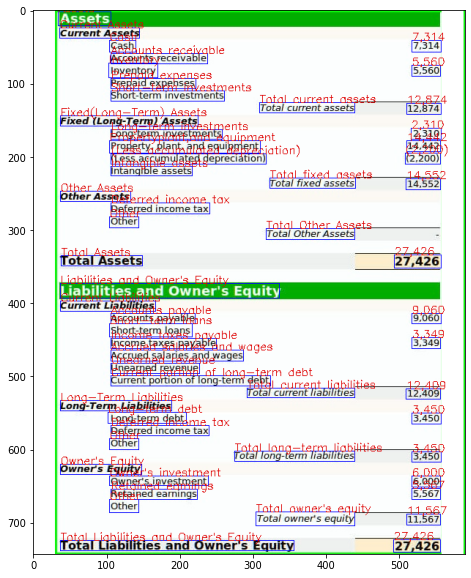

In [1183]:
for box,text in zip(boxes,texts):
  cv2.rectangle(image_boxes, (int(box[0][0]),int(box[0][1])), (int(box[2][0]),int(box[2][1])),(0,0,255),1)
  cv2.putText(image_boxes, text,(int(box[0][0]),int(box[0][1])),cv2.FONT_HERSHEY_SIMPLEX,0.5,(222,0,0),1)

# Showing the image
plt.figure(figsize=(20,10))
plt.imshow(image_boxes)

In [1184]:
cv2.imwrite('detections.jpg', image_boxes)

True

# V. Reconstruction

## i. Get Horizontal and Vertical Lines

In [1185]:
im = image_cv.copy()

In [1186]:
horiz_boxes = []
vert_boxes = []

for box in boxes:
  x_h, x_v = 0,int(box[0][0])
  y_h, y_v = int(box[0][1]),0
  width_h,width_v = image_width, int(box[2][0]-box[0][0])
  height_h,height_v = int(box[2][1]-box[0][1]),image_height

  horiz_boxes.append([x_h,y_h,x_h+width_h,y_h+height_h])
  vert_boxes.append([x_v,y_v,x_v+width_v,y_v+height_v])

  cv2.rectangle(im,(x_h,y_h), (x_h+width_h,y_h+height_h),(0,0,255),1)
  cv2.rectangle(im,(x_v,y_v), (x_v+width_v,y_v+height_v),(0,255,0),1)
  

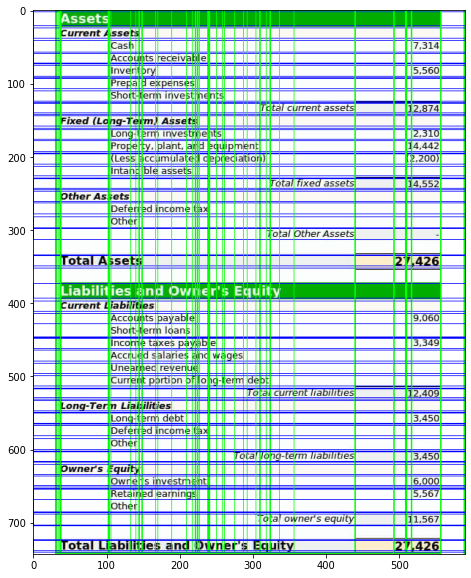

In [1187]:
# Showing the image
plt.figure(figsize=(20,10))
plt.imshow(im)

In [1188]:
cv2.imwrite('horiz_vert.jpg',im)

True

## ii. Non-Max Suppression

In [1189]:
horiz_out = tf.image.non_max_suppression(
    horiz_boxes,
    probabilities,
    max_output_size = 1000,
    iou_threshold=0.1,
    score_threshold=float('-inf'),
    name=None
)

In [1190]:
horiz_lines = np.sort(np.array(horiz_out))
print(horiz_lines)

[ 0  1  2  4  5  7  8 10 11 12 15 16 18 19 21 22 23 24 26 27 28 29 31 33
 34 35 36 38 39 40 42 43 44 46 48 49 51 53 55]


In [1191]:
im_nms = image_cv.copy()

In [1192]:
for val in horiz_lines:
  cv2.rectangle(im_nms, (int(horiz_boxes[val][0]),int(horiz_boxes[val][1])), (int(horiz_boxes[val][2]),int(horiz_boxes[val][3])),(0,0,255),1)
  

In [1193]:
cv2.imwrite('im_nms.jpg',im_nms)

True

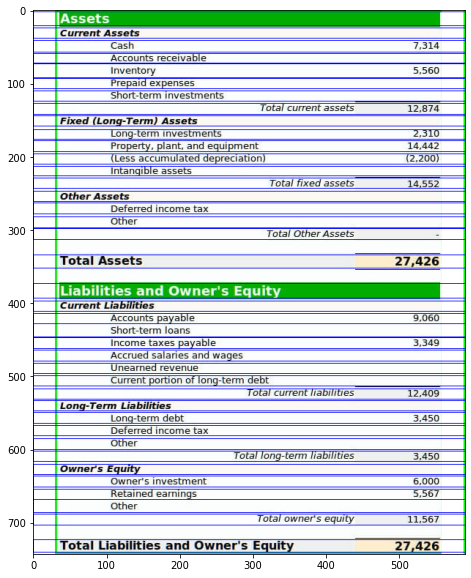

In [1194]:
# Showing the image
plt.figure(figsize=(20,10))
plt.imshow(im_nms)

In [1195]:
vert_out = tf.image.non_max_suppression(
    vert_boxes,
    probabilities,
    max_output_size = 1000,
    iou_threshold=0.05,
    score_threshold=float('-inf'),
    name=None,
)

In [1196]:
vert_lines = np.sort(np.array(vert_out))
print(vert_lines)

[ 0 43 44 53]


In [1197]:
im_nms = image_cv.copy()

In [1198]:
# Deleting empty boxes
tmp = vert_lines.copy()
for i in vert_lines:
  if (abs(vert_boxes[i][2] - vert_boxes[i][0]) < 10) or (abs(vert_boxes[i][1] - vert_boxes[i][3]) < 10) :
    print(i)
    tmp.remove(i)
vert_lines = tmp

In [1199]:
for val in vert_lines:
  cv2.rectangle(im_nms, (int(vert_boxes[val][0]),int(vert_boxes[val][1])), (int(vert_boxes[val][2]),int(vert_boxes[val][3])),(255,0,0),1)
  

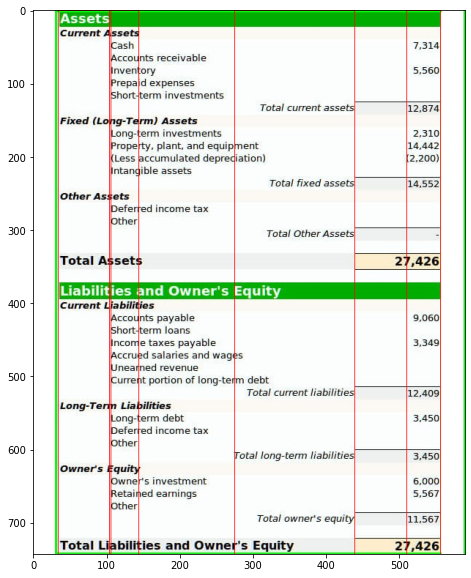

In [1200]:
# Showing the image
plt.figure(figsize=(20,10))
plt.imshow(im_nms)

In [1201]:
# cv2.imwrite('im_nms.jpg',im_nms)

# IV. Conversion

## i. Convert to CSV

In [1202]:
out_array = [["" for i in range(len(vert_lines))] for j in range(len(horiz_lines))]
print(np.array(out_array).shape)
print(out_array)

(39, 4)
[['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', ''], ['', '', '', '']]


In [1203]:
unordered_boxes = []

for i in vert_lines:
  print(vert_boxes[i])
  unordered_boxes.append(vert_boxes[i][0])

[34, 0, 106, 743]
[104, 0, 144, 743]
[275, 0, 439, 743]
[510, 0, 556, 743]


In [1204]:
ordered_boxes = np.argsort(unordered_boxes)
print(ordered_boxes)

[0 1 2 3]


In [1205]:
def intersection(box_1, box_2):
  return [box_2[0], box_1[1],box_2[2], box_1[3]]

In [1206]:
def iou(box_1, box_2):

  x_1 = max(box_1[0], box_2[0])
  y_1 = max(box_1[1], box_2[1])
  x_2 = min(box_1[2], box_2[2])
  y_2 = min(box_1[3], box_2[3])

  inter = abs(max((x_2 - x_1, 0)) * max((y_2 - y_1), 0))
  if inter == 0:
      return 0
      
  box_1_area = abs((box_1[2] - box_1[0]) * (box_1[3] - box_1[1]))
  box_2_area = abs((box_2[2] - box_2[0]) * (box_2[3] - box_2[1]))
  
  return inter / float(box_1_area + box_2_area - inter)

In [1207]:
for i in range(len(horiz_lines)):
  for j in range(len(vert_lines)):
    resultant = intersection(horiz_boxes[horiz_lines[i]], vert_boxes[vert_lines[ordered_boxes[j]]] )

    for b in range(len(boxes)):
      the_box = [boxes[b][0][0],boxes[b][0][1],boxes[b][2][0],boxes[b][2][1]]
      if(iou(resultant,the_box)>0.1) and (texts[b] != out_array[i][j-1]):
        out_array[i][j] = texts[b]

In [1208]:
out_array

[['Assets', '', '', ''],
 ['Current Assets', '', '', ''],
 ['', 'Cash', '', '7,314'],
 ['', 'Accounts receivable', '', ''],
 ['', 'Inventory', '', '5,560'],
 ['', 'Prepaid expenses', '', ''],
 ['', 'Short-term investments', '', ''],
 ['', '', 'Total current assets', '12,874'],
 ['Fixed(Long-Term) Assets', '', '', ''],
 ['', 'Long-term investments', '', '2,310'],
 ['', 'Propertyplant,and equipment', '', '14,442'],
 ['', '(Less accumulated depreciation)', '', '(2,200)'],
 ['', 'Intangible assets', '', ''],
 ['', '', 'Total fixed assets', '14,552'],
 ['Other Assets', '', '', ''],
 ['', 'Deferred income tax', '', ''],
 ['', 'Other', '', ''],
 ['', '', 'Total Other Assets', ''],
 ['Total Assets', '', '', '27,426'],
 ["Liabilities and Owner's Equity", '', "Liabilities and Owner's Equity", ''],
 ['Current Liabilities', '', '', ''],
 ['', 'Accounts payable', '', '9,060'],
 ['', 'Short-term loans', '', ''],
 ['', 'Income taxes payable', '', '3,349'],
 ['', 'Accrued salaries and wages', '', ''],

In [1209]:
out_array = np.array(out_array)

In [1210]:
pd.DataFrame(out_array).to_csv('sample.csv')

## ii. Convert to JSON format

In [1211]:
import csv 
import json 

def csv_to_json(csvFilePath, jsonFilePath):
    jsonArray = []
      
    #read csv file
    with open(csvFilePath, encoding='utf-8') as csvf: 
        #load csv file data using csv library's dictionary reader
        csvReader = csv.DictReader(csvf) 

        #convert each csv row into python dict
        for row in csvReader: 
            #add this python dict to json array
            jsonArray.append(row)
  
    #convert python jsonArray to JSON String and write to file
    with open(jsonFilePath, 'w', encoding='utf-8') as jsonf: 
        jsonString = json.dumps(jsonArray, indent=4)
        jsonf.write(jsonString)
          
csvFilePath = r'sample.csv'
jsonFilePath = r'data.json'
csv_to_json(csvFilePath, jsonFilePath)

In [1212]:
fileObject = open("data.json", "r")
jsonContent = fileObject.read()
aList = json.loads(jsonContent)
print(aList)

[{'': '0', '0': 'Assets', '1': '', '2': '', '3': ''}, {'': '1', '0': 'Current Assets', '1': '', '2': '', '3': ''}, {'': '2', '0': '', '1': 'Cash', '2': '', '3': '7,314'}, {'': '3', '0': '', '1': 'Accounts receivable', '2': '', '3': ''}, {'': '4', '0': '', '1': 'Inventory', '2': '', '3': '5,560'}, {'': '5', '0': '', '1': 'Prepaid expenses', '2': '', '3': ''}, {'': '6', '0': '', '1': 'Short-term investments', '2': '', '3': ''}, {'': '7', '0': '', '1': '', '2': 'Total current assets', '3': '12,874'}, {'': '8', '0': 'Fixed(Long-Term) Assets', '1': '', '2': '', '3': ''}, {'': '9', '0': '', '1': 'Long-term investments', '2': '', '3': '2,310'}, {'': '10', '0': '', '1': 'Propertyplant,and equipment', '2': '', '3': '14,442'}, {'': '11', '0': '', '1': '(Less accumulated depreciation)', '2': '', '3': '(2,200)'}, {'': '12', '0': '', '1': 'Intangible assets', '2': '', '3': ''}, {'': '13', '0': '', '1': '', '2': 'Total fixed assets', '3': '14,552'}, {'': '14', '0': 'Other Assets', '1': '', '2': '', 